In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
from torch import nn


class SeperableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1, bias=True):
        super(SeperableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(
            in_channels,
            in_channels,
            kernel_size=kernel_size,
            stride = stride,
            groups=in_channels,
            bias=bias,
            padding=padding
        )
        self.pointwise = nn.Conv2d(
            in_channels,
            out_channels, 
            kernel_size=1,
            bias=bias
        )
    def forward(self, x):
        return self.pointwise(self.depthwise(x))
    

    
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act=True, use_bn=True, discriminator=False, **kwargs):
        super(ConvBlock, self).__init__()
        
        self.use_act = use_act
        self.cnn = SeperableConv2d(in_channels, out_channels, **kwargs, bias=not use_bn)
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.act = nn.LeakyReLU(0.2, inplace=True) if discriminator else nn.PReLU(num_parameters=out_channels)
        
    def forward(self, x):
        return self.act(self.bn(self.cnn(x))) if self.use_act else self.bn(self.cnn(x))


class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super(UpsampleBlock, self).__init__()
        
        self.conv = SeperableConv2d(in_channels, in_channels * scale_factor**2, kernel_size=3, stride=1, padding=1)
        self.ps = nn.PixelShuffle(scale_factor) # (in_channels * 4, H, W) -> (in_channels, H*2, W*2)
        self.act = nn.PReLU(num_parameters=in_channels)
    
    def forward(self, x):
        return self.act(self.ps(self.conv(x)))
        

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        
        self.block1 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.block2 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            use_act=False
        )
        
    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        return out + x
    
    
class Generator(nn.Module):
    """Swift-SRGAN Generator
    Args:
        in_channels (int): number of input image channels.
        num_channels (int): number of hidden channels.
        num_blocks (int): number of residual blocks.
        upscale_factor (int): factor to upscale the image [2x, 4x, 8x].
    Returns:
        torch.Tensor: super resolution image
    """

    def __init__(self, in_channels: int = 3, num_channels: int = 64, num_blocks: int = 16, upscale_factor: int = 4):
        super(Generator, self).__init__()
        
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=9, stride=1, padding=4, use_bn=False)
        self.residual = nn.Sequential(
            *[ResidualBlock(num_channels) for _ in range(num_blocks)]
        )
        self.convblock = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_act=False)
        self.upsampler = nn.Sequential(
            *[UpsampleBlock(num_channels, scale_factor=2) for _ in range(upscale_factor//2)]
        )
        self.final_conv = SeperableConv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=4)
        
    def forward(self, x):
        initial = self.initial(x)
        x = self.residual(initial)
        x = self.convblock(x) + initial
        x = self.upsampler(x)
        return (torch.tanh(self.final_conv(x)) + 1) / 2


In [3]:
from torchvision.models import mobilenet_v2


class GeneratorLoss(nn.Module):
    def __init__(self,device="cuda:0"):
        super(GeneratorLoss, self).__init__()
        vgg = mobilenet_v2(pretrained=True)
        self.device = device
        loss_network = nn.Sequential(*list(vgg.features)).eval()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network.to(self.device)
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()

    def forward(self, out_labels, out_images, target_images):
        # Adversarial Loss
        adversarial_loss = torch.mean(1 - out_labels)
        # Perception Loss
        perception_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))
        # Image Loss
        image_loss = self.mse_loss(out_images, target_images)
        # TV Loss
        tv_loss = self.tv_loss(out_images)
        return image_loss + 0.001 * adversarial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]


if __name__ == "__main__":
    g_loss = GeneratorLoss()
    print(g_loss)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 156MB/s]


GeneratorLoss(
  (loss_network): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96

In [4]:
from os import listdir
from os.path import join

from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size,pad_if_needed=True),
        ToTensor(),
    ])


def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])


def display_transform():
    return Compose([
        ToPILImage(),
        Resize(400),
        CenterCrop(400),
        ToTensor()
    ])


class TrainDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)


class ValDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, upscale_factor):
        super(ValDatasetFromFolder, self).__init__()
        self.upscale_factor = upscale_factor
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]

    def __getitem__(self, index):
        hr_image = Image.open(self.image_filenames[index])
        w, h = hr_image.size
        crop_size = calculate_valid_crop_size(min(w, h), self.upscale_factor)
        lr_scale = Resize(crop_size // self.upscale_factor, interpolation=Image.BICUBIC)
        hr_scale = Resize(crop_size, interpolation=Image.BICUBIC)
        hr_image = CenterCrop(crop_size)(hr_image)
        lr_image = lr_scale(hr_image)
        hr_restore_img = hr_scale(lr_image)
        return ToTensor()(lr_image), ToTensor()(hr_restore_img), ToTensor()(hr_image)

    def __len__(self):
        return len(self.image_filenames)


class TestDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, upscale_factor):
        super(TestDatasetFromFolder, self).__init__()
        self.lr_path = dataset_dir + '/SRF_' + str(upscale_factor) + '/data/'
        self.hr_path = dataset_dir + '/SRF_' + str(upscale_factor) + '/target/'
        self.upscale_factor = upscale_factor
        self.lr_filenames = [join(self.lr_path, x) for x in listdir(self.lr_path) if is_image_file(x)]
        self.hr_filenames = [join(self.hr_path, x) for x in listdir(self.hr_path) if is_image_file(x)]

    def __getitem__(self, index):
        image_name = self.lr_filenames[index].split('/')[-1]
        lr_image = Image.open(self.lr_filenames[index])
        w, h = lr_image.size
        hr_image = Image.open(self.hr_filenames[index])
        hr_scale = Resize((self.upscale_factor * h, self.upscale_factor * w), interpolation=Image.BICUBIC)
        hr_restore_img = hr_scale(lr_image)
        return image_name, ToTensor()(lr_image), ToTensor()(hr_restore_img), ToTensor()(hr_image)

    def __len__(self):
        return len(self.lr_filenames)

In [5]:
class DiscriminatorBlock(nn.Module):

    def __init__(self,in_channel,out_channel,stride):
        super().__init__()
        #self.conv = nn.Conv2d(in_channel,out_channel,(3,3),(stride,stride))
        self.conv = SeperableConv2d(in_channel,out_channel,3,stride,bias=True)
        self.norm = nn.BatchNorm2d(out_channel)
        self.activation = nn.LeakyReLU(0.2, inplace=True)


    def forward(self,x):
        x = self.conv(x)
        x = self.norm(x)
        self.activation(x)
        return x 
    

class Discriminator(nn.Module):
    def __init__(self,in_channel):
        super().__init__()
        #self.input_conv = nn.Conv2d(in_channel,64,(3,3),(1,1))
        self.input_conv = SeperableConv2d(in_channel,64,3,2,bias=False)
        self.activation = nn.LeakyReLU()
        parameters= [(64,128,1),(128,128,2),(128,256,1),(256,256,2),(256,512,1),(512,512,2),(512,512,1)]
        self.blocks = [DiscriminatorBlock(parameters[i][0],parameters[i][1],parameters[i][2]).cuda() for i in range(len(parameters))]
        self.pooling = nn.AdaptiveAvgPool2d((6, 6))
        self.dense_1 = nn.Linear(512*6*6,1024)
        self.activation_dense= nn.LeakyReLU(0.2, inplace=True)
        self.out =nn.Linear(1024,1)
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()


    def forward(self,x):
        x = self.input_conv(x)
        x = self.activation(x)
        for layer in self.blocks :
            x = layer(x)
        x = self.pooling(x)
        x = self.dense_1(self.flatten(x))
        x = self.activation_dense(x)
        x = self.sigmoid(x)
        return x



In [6]:
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

DEVICE = "cuda:0"   
UP_FACTOR = 4

# def train(epochs = 100):
#     generator_criterion = GeneratorLoss(DEVICE)
#     train_set = TrainDatasetFromFolder('/kaggle/input/df2kdata/DF2K_train_HR',
#                  crop_size=96, upscale_factor=UP_FACTOR)
#     val_set = ValDatasetFromFolder('/kaggle/input/df2kdata/DF2K_valid_HR', 
#                  upscale_factor=UP_FACTOR)
#     train_loader = DataLoader(dataset=train_set, num_workers=1, 
#                  batch_size=32, shuffle=True)
#     val_loader = DataLoader(dataset=val_set, num_workers=1,
#                  batch_size=1, shuffle=False)

#     generator = Generator(3)
#     discriminator = Discriminator(3)
#     if torch.cuda.is_available():
#         generator = generator.to(DEVICE)
#         discriminator = discriminator.to(DEVICE)
#     optimizerG = optim.Adam(generator.parameters())
#     optimizerD = optim.Adam(discriminator.parameters())

#     generator.train()
#     discriminator.train()

#     for epoch in range(epochs+1) :
#         for data,target in tqdm(train_loader) :
#             discriminator.zero_grad()
#             if torch.cuda.is_available():
#                 target = target.to(DEVICE)
#                 data = data.to(DEVICE)
#             fake_img = generator(data)
#             real_img = target

#             fake_out = discriminator(fake_img)
#             real_out = discriminator(real_img)
#             d_loss = 1 - real_out.mean() + fake_out.mean()
#             d_loss.backward()
#             optimizerD.step()

#             generator.zero_grad()
#             fake_img = generator(data)
#             fake_out = discriminator(fake_img)
#             g_loss =  generator_criterion(fake_out, fake_img, real_img)
#             g_loss.backward()
#             optimizerG.step()

#         print(f" Epoch : {epoch} generator loss : {g_loss} discriminator loss {d_loss}")
#         torch.save(
#             {"model": generator.state_dict()},
#             f"/kaggle/working//netG_{UP_FACTOR}x_epoch{epoch}.pth.tar",
#         )
#         torch.save(
#             {"model": discriminator.state_dict()},
#             f"/kaggle/working//netD_{UP_FACTOR}x_epoch{epoch}.pth.tar",
#                 )
#     generator.eval()
#     discriminator.eval()
#     with torch.no_grad():
#         for batch,(data,_ ,target) in enumerate(val_loader) :
#             discriminator.zero_grad()
#             if torch.cuda.is_available():
#                 target = target.to(DEVICE)
#                 data = data.to(DEVICE)
#             fake_img = generator(data)
#             real_img = target

#             batch_mse = ((fake_img - real_img) ** 2).data.mean()

#         print(f"MSE values at batch {batch} is {batch_mse}")
    
# if __name__ == '__main__' :
#     train(100)

In [7]:
checkpoint = torch.load("/kaggle/input/netd_4x_epoch100-1/pytorch/default/1/netD_4x_epoch100-1.pth.tar")

<ipython-input-7-6ab3f7d31588>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/netd_4x_epoch100-1/pytorch/default/1/netD_4x_epoch100-

<ipython-input-17-b59f34c3fc3f>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/netd_4x_epoch100-1/pytorch/default/1/netD_4x_epoch10

gt_image (255, 339, 3)
sr_img torch.Size([1, 3, 1020, 1356])


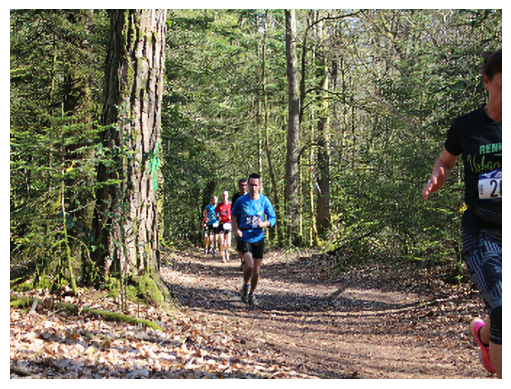

In [17]:
import math
import torchvision
import argparse
import matplotlib.pyplot as plt 
import cv2
from torchvision import transforms

torch.backends.cudnn.benchmark = True
torch.cuda.manual_seed_all(42)
UPSCALE_FACTOR = 4

if __name__ == "__main__" :
    DEVICE = torch.device("cuda:0")
    netG = Generator().to(DEVICE)
    checkpoint = torch.load("/kaggle/input/netd_4x_epoch100-1/pytorch/default/1/netD_4x_epoch100-1.pth.tar")
    netG.load_state_dict(checkpoint['model'])
    path_to_image = "/kaggle/input/df2kdata/DF2K_train_LR_bicubic/X2/000001x2.png"
    gt_image = cv2.imread(path_to_image).astype(np.float32) / 255.
    gt_image = cv2.cvtColor(gt_image, cv2.COLOR_BGR2RGB)
   
    gt_image =  cv2.resize(gt_image, (int(gt_image.shape[0]/2),int(gt_image.shape[1]/4)), cv2.INTER_CUBIC)
    img = plt.imshow(gt_image)
    plt.axis('off')
    plt.savefig('demo_real.png', bbox_inches='tight')
    print("gt_image",gt_image.shape)
    gt_tensor = transforms.ToTensor()(gt_image).unsqueeze(0).to(DEVICE)
    sr_img = netG(gt_tensor)
    print("sr_img",sr_img.shape)
    sr_image = transforms.ToPILImage()(sr_img.squeeze().detach().cpu())

    img = plt.imshow(sr_image)
    plt.axis('off')
    plt.savefig('demo_upgrade.png', bbox_inches='tight')

In [18]:
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(42)


DEVICE = torch.device("cuda:0")

def load_trained_model(path= "/kaggle/input/netd_4x_epoch100-1/pytorch/default/1/netD_4x_epoch100-1.pth.tar") :
    netG = Generator(upscale_factor=UPSCALE_FACTOR).to(DEVICE)
    checkpoint = torch.load(path)
    netG.load_state_dict(checkpoint['model'])
    return netG

In [11]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
TG_TOKEN = user_secrets.get_secret("TG_TOKEN")

In [12]:
!pip install aiogram nest_asyncio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.0/610.0 kB 13.9 MB/s eta 0:00:0000:01
  Attempting uninstall: aiofiles
    Found existing installation: aiofiles 22.1.0
    Uninstalling aiofiles-22.1.0:
      Successfully uninstalled aiofiles-22.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ypy-websocket 0.8.4 requires aiofiles<23,>=22.1.0, but you have aiofiles 24.1.0 which is incompatible.


In [19]:
import io
import cv2
import nest_asyncio
import asyncio
from aiogram import Bot, Dispatcher, types
from aiogram.types import Message
from aiogram.filters import Command
from aiogram.fsm.storage.memory import MemoryStorage
from PIL import Image

# Apply nest_asyncio to allow nested event loops
nest_asyncio.apply()

model = netG
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model.to(DEVICE).eval()

# Initialize bot and dispatcher
bot = Bot(token=TG_TOKEN)
dp = Dispatcher(storage=MemoryStorage())

# Start command handler
@dp.message(Command("start"))
async def start_command(message: Message):
    await message.answer("👋 Hello! Send me an image, and I'll upscale it for you!")

# Function to process images
async def process_image(image_bytes):
    print("🔄 Processing image...")
    try:
        image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
        print(f"📏 Original image size: {image.size}")

        gt_image = np.array(image).astype(np.float32) / 255.0
        gt_image = cv2.resize(gt_image, (gt_image.shape[1] // 2, gt_image.shape[0] // 2), cv2.INTER_CUBIC)

        gt_tensor = transforms.ToTensor()(gt_image).unsqueeze(0)
        print(f"📊 Input Tensor Shape: {gt_tensor.shape}")

        sr_img = model(gt_tensor.to(DEVICE))
        print(f"📈 Output Tensor Shape: {sr_img.shape}")

        sr_image = transforms.ToPILImage()(sr_img.squeeze().detach().cpu())
        sr_image.show()  # Show the image to verify

        output_io = io.BytesIO()
        sr_image.save(output_io, format='PNG')
        output_io.seek(0)
        
        print("✅ Image processing completed!")
        return output_io
    except Exception as e:
        print(f"❌ Error during processing: {e}")
        return None


@dp.message(lambda message: message.photo)
async def handle_image(message: Message):
    print("📸 Image received!")
    photo = message.photo[-1]  # Get highest resolution
    photo_file = await bot.download(photo)

    file_bytes = photo_file.getvalue()
    print(f"📦 Downloaded file size: {len(file_bytes)} bytes")

    if len(file_bytes) == 0:
        await message.answer("⚠️ Error: Could not download the image.")
        return

    await message.answer("🔄 Processing your image, please wait...")
    
    processed_image = await process_image(file_bytes)
    
    if processed_image is None:
        await message.answer("⚠️ Error: Image processing failed.")
        return

    try:
        processed_image.seek(0)  # Ensure pointer is at the start
        await message.answer_photo(types.BufferedInputFile(processed_image.read(), filename="upscaled.png"), caption="✨ Here is your upscaled image!")
        print("✅ Image successfully sent!")
    except Exception as e:
        print(f"❌ Telegram API Error: {e}")
        await message.answer("⚠️ Error sending the image back.")

# Main function to run the bot
async def main():
    print("🤖 Bot is running...")
    await dp.start_polling(bot)

# Run the bot
loop = asyncio.get_event_loop()
loop.create_task(main())

<Task pending name='Task-1' coro=<main() running at <ipython-input-19-a5ebb3c6e3cb>:87>>

🤖 Bot is running...
📸 Image received!
📦 Downloaded file size: 14237 bytes
🔄 Processing image...
📏 Original image size: (320, 320)
📊 Input Tensor Shape: torch.Size([1, 3, 160, 160])
📈 Output Tensor Shape: torch.Size([1, 3, 640, 640])
✅ Image processing completed!
✅ Image successfully sent!
📸 Image received!
📦 Downloaded file size: 14237 bytes
🔄 Processing image...
📏 Original image size: (320, 320)
📊 Input Tensor Shape: torch.Size([1, 3, 160, 160])
📈 Output Tensor Shape: torch.Size([1, 3, 640, 640])
✅ Image processing completed!
✅ Image successfully sent!
📸 Image received!
📦 Downloaded file size: 14237 bytes
🔄 Processing image...
📏 Original image size: (320, 320)
📊 Input Tensor Shape: torch.Size([1, 3, 160, 160])
📈 Output Tensor Shape: torch.Size([1, 3, 640, 640])
✅ Image processing completed!
✅ Image successfully sent!
